In [1]:

!pip install konlpy  # Install the missing 'konlpy' module
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt  # Now you should be able to import 'Okt'

import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
# fontpath = 'C:\Windows\Fonts\MALGUNSL.TTF'  # Update this path if necessary for Linux
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # Example path for NanumBarunGothic on Linux
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

# Rebuild font cache (use public method)
fm.fontManager.addfont(fontpath)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 30.6 MB/s eta 0:00:00
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7d8888e13e20>)

In [3]:
train_data = pd.read_table('ratings.txt')
print("data count : ",len(train_data))
train_data[:5] # 상위 5개 출력

data count :  200000


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


null값 찾기

In [4]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
46471,6369843,NaN,1
60735,511097,NaN,1
77665,2172111,NaN,1
84098,402110,NaN,1
127017,5942978,NaN,0
172375,5026896,NaN,0
173526,1034280,NaN,0
197279,1034283,NaN,0


In [5]:
print(train_data['document'].isnull().sum())

8


In [6]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [7]:
okt = Okt()
def tokenize(doc):
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [8]:
#형태소 분석 ( 오타, 줄임말 등으로 분석이 나쁘게 될 수 있음 )
print(train_data.iloc[0,1], '\n')
tokenize(train_data.iloc[0,1])

어릴때보고 지금다시봐도 재밌어요ㅋㅋ 



['어리다/Verb',
 '때/Noun',
 '보고/Noun',
 '지금/Noun',
 '다시/Noun',
 '보다/Verb',
 '재밌다/Adjective',
 'ㅋㅋ/KoreanParticle']

In [9]:
# 정규 표현식을 통한 한글 외 문자 제거
#정규표현식을 이용해 한글 문자와 공백을 제외한 구두점, 특수문자 등을 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [10]:
#와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런... -> 특수문자 제거
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [11]:
!pip install tqdm
from tqdm import tqdm # Import the tqdm module
# 불용어 정의
#불용어는 자주 등장하지만 분석을 하는 데에 있어서는 도움이 되지 않는 단어
#'나', '너'와 같은 단어나 조사, 접미사는 문장에서 자주 등장 -> 의미 없는 데이터
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


100%|██████████| 199992/199992 [13:07<00:00, 253.93it/s]


In [12]:
#불용어를 제외한 '형태소/품사' 데이터
tokenized_data[0:5]

[['어리다', '때', '보고', '지금', '다시', '보다', '재밌다', 'ㅋㅋ'],
 ['디자인',
  '을',
  '배우다',
  '학생',
  '외국',
  '디자이너',
  '그',
  '일군',
  '전통',
  '을',
  '통해',
  '발전',
  '문화',
  '산업',
  '부럽다',
  '사실',
  '우리나라',
  '에서도',
  '그',
  '어렵다',
  '시절',
  '끝',
  '까지',
  '열정',
  '을',
  '지키다',
  '노라노',
  '같다',
  '전통',
  '있다',
  '저',
  '같다',
  '사람',
  '꿈',
  '을',
  '꾸다',
  '이루다',
  '나가다',
  '수',
  '있다',
  '것',
  '감사하다'],
 ['폴리스스토리', '시리즈', '부터', '뉴', '까지', '버리다', '하나', '없다', '최고'],
 ['오다',
  '연기',
  '진짜',
  '개',
  '쩔다',
  '지루하다',
  '생각',
  '몰입',
  '보다',
  '그렇다',
  '이렇다',
  '진짜',
  '영화',
  '지'],
 ['안개', '자욱하다', '밤하늘', '뜨다', '있다', '초승달', '같다', '영화']]

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


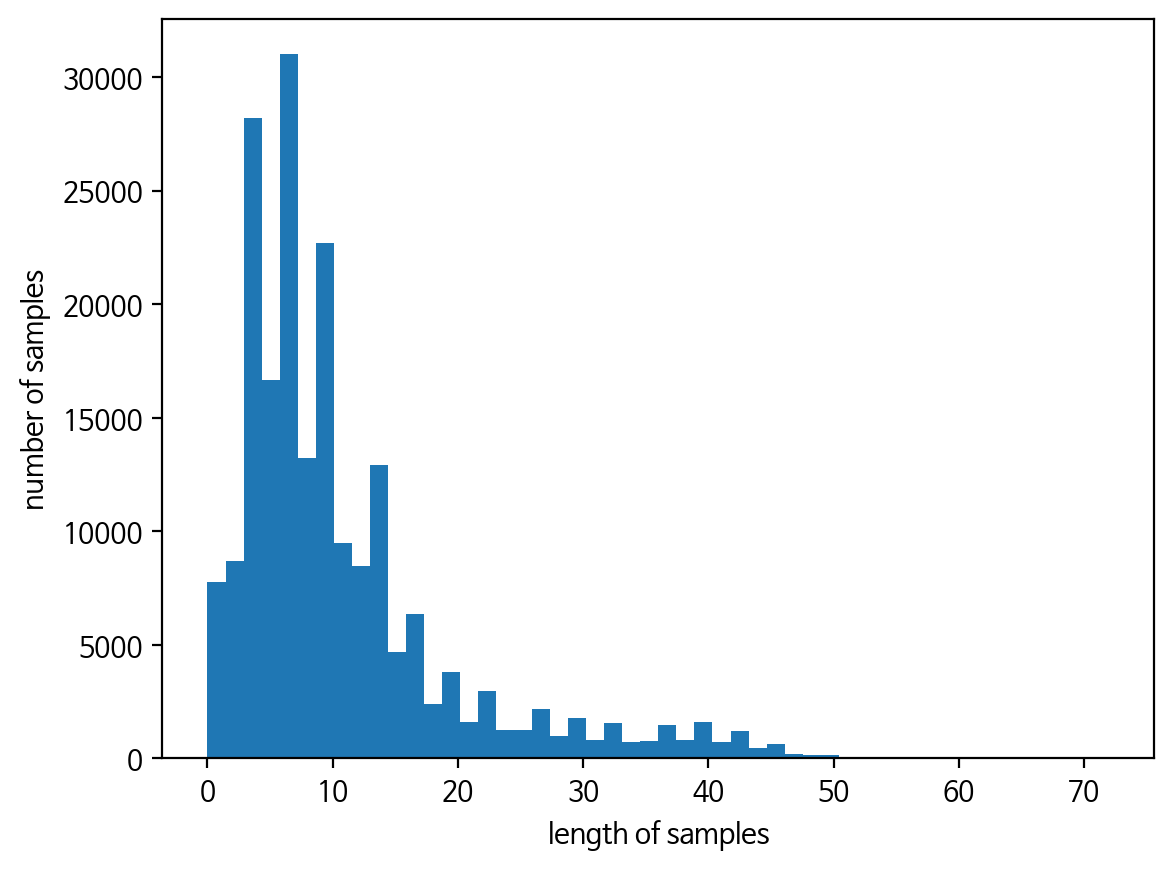

In [13]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
import numpy as np
from gensim.models import Word2Vec

# 벡터 100 차원, 윈도우 사이즈 5, 빈도 5회 이상 단어만 학습
# workers 수를 줄여서 메모리 사용량과 CPU 사용량을 줄임
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=5, workers=2, sg=0)

In [15]:
word_vectors = model.wv
vocabs = word_vectors.key_to_index.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

# 학습이 잘 되었는지 확인하는 코드 추가
print(f"Number of words in vocabulary: {len(vocabs)}")
print(f"Vector for the first word in vocabulary: {word_vectors_list[0]}")

Number of words in vocabulary: 16477
Vector for the first word in vocabulary: [ 0.8113556  -0.54036397 -0.95535314  0.5854183  -2.0543838  -0.7283186
  0.20674098  0.42270616 -0.71832347 -0.3207024   0.9007543   0.58303225
 -1.4718864   2.1901402  -1.3486029   0.32402667  0.21290034  0.55224687
 -0.6104482   0.11348725 -1.7172985   0.08967122  0.5976298  -0.02230642
 -0.64783967  1.1746188  -0.003612   -0.19283286  0.14870822  0.6551617
 -0.07388973 -1.3877563   0.6039109  -0.8837412  -1.1582186   1.0205908
  0.8236253  -0.6017188  -0.1256617   0.08379625 -0.54893494  0.75070167
 -0.4255246  -1.0195398  -1.7854604   0.05005712  0.11082277  1.3204575
  1.3616774   1.2913351  -1.9102094  -0.3608074  -0.83492005  0.7389631
  2.0033498  -0.26955125  1.147099   -1.0241683  -0.62734413  0.16111863
  0.22239292  0.03443392 -2.129309   -0.8417036  -0.26671144 -0.17821892
  0.66137874 -0.818172   -1.2285552   0.3297764   0.19533199 -0.7487157
 -0.9521179  -0.9636902   0.6072566   0.33421332 -1.

In [16]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [17]:
#유사 단어 찾기
print(model.wv.most_similar("최민식"))

[('안성기', 0.8767093420028687), ('김명민', 0.8411263823509216), ('김수현', 0.8283105492591858), ('한석규', 0.8233804106712341), ('미스캐스팅', 0.8211390972137451), ('설경구', 0.8196618556976318), ('이민호', 0.8134440183639526), ('송강호', 0.8134422302246094), ('서영희', 0.8107084631919861), ('류덕환', 0.803286612033844)]


In [18]:
print(model.wv.most_similar("히어로"))

[('호러', 0.8624647855758667), ('물의', 0.8543015122413635), ('슬래셔', 0.8514891266822815), ('무협', 0.8505938053131104), ('느와르', 0.8346049189567566), ('물', 0.8218437433242798), ('정통', 0.8127709627151489), ('블록버스터', 0.8040716052055359), ('무비', 0.8034856915473938), ('헐리우드', 0.7776284217834473)]


In [19]:
print(model.wv.similarity('한국', '일본'))

0.77247626


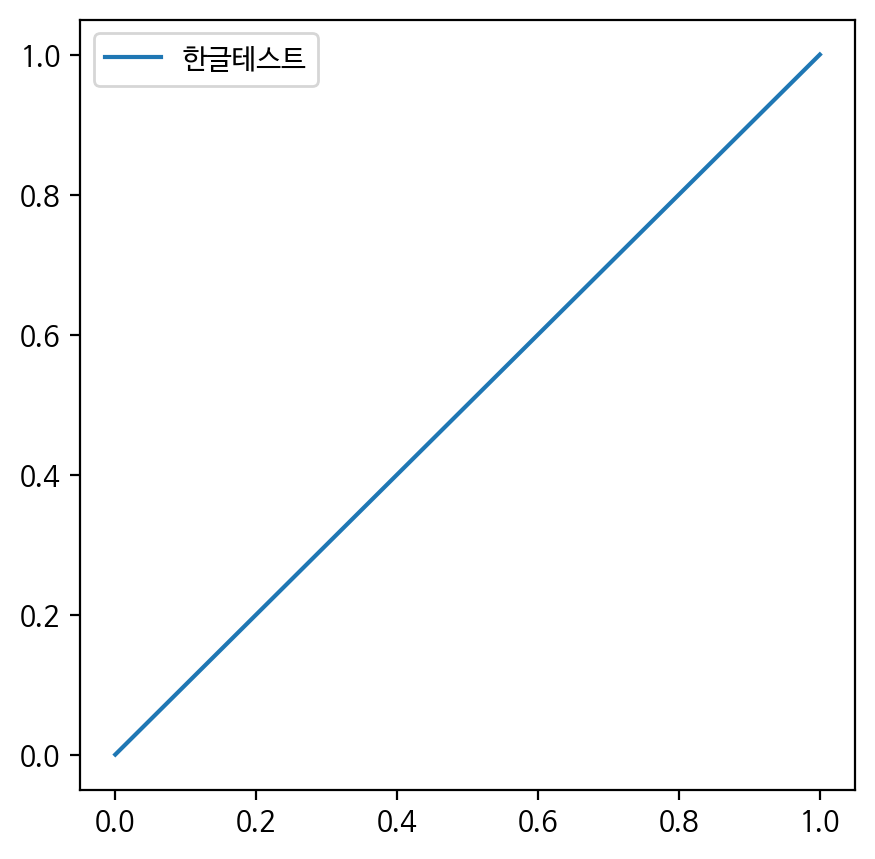

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트')
plt.legend()
plt.show()

In [21]:
#임베딩 결과 시각화
#100차원 벡터를 시각화하기 위해서는 2,3 차원으로 축소해야한다.
from sklearn.decomposition import PCA

#2차원으로 축소
pca = PCA(n_components=2)

xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

In [22]:
#단어와 2차원 x축 값, y축의 갓을 입력받아 2차원 그래프를 그린다.
def plot_2d_graph(vocabs, xs, ys):
  plt.figure(figsize=(25,15))
  plt.scatter(xs, ys, marker = 'o')
  for i,v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


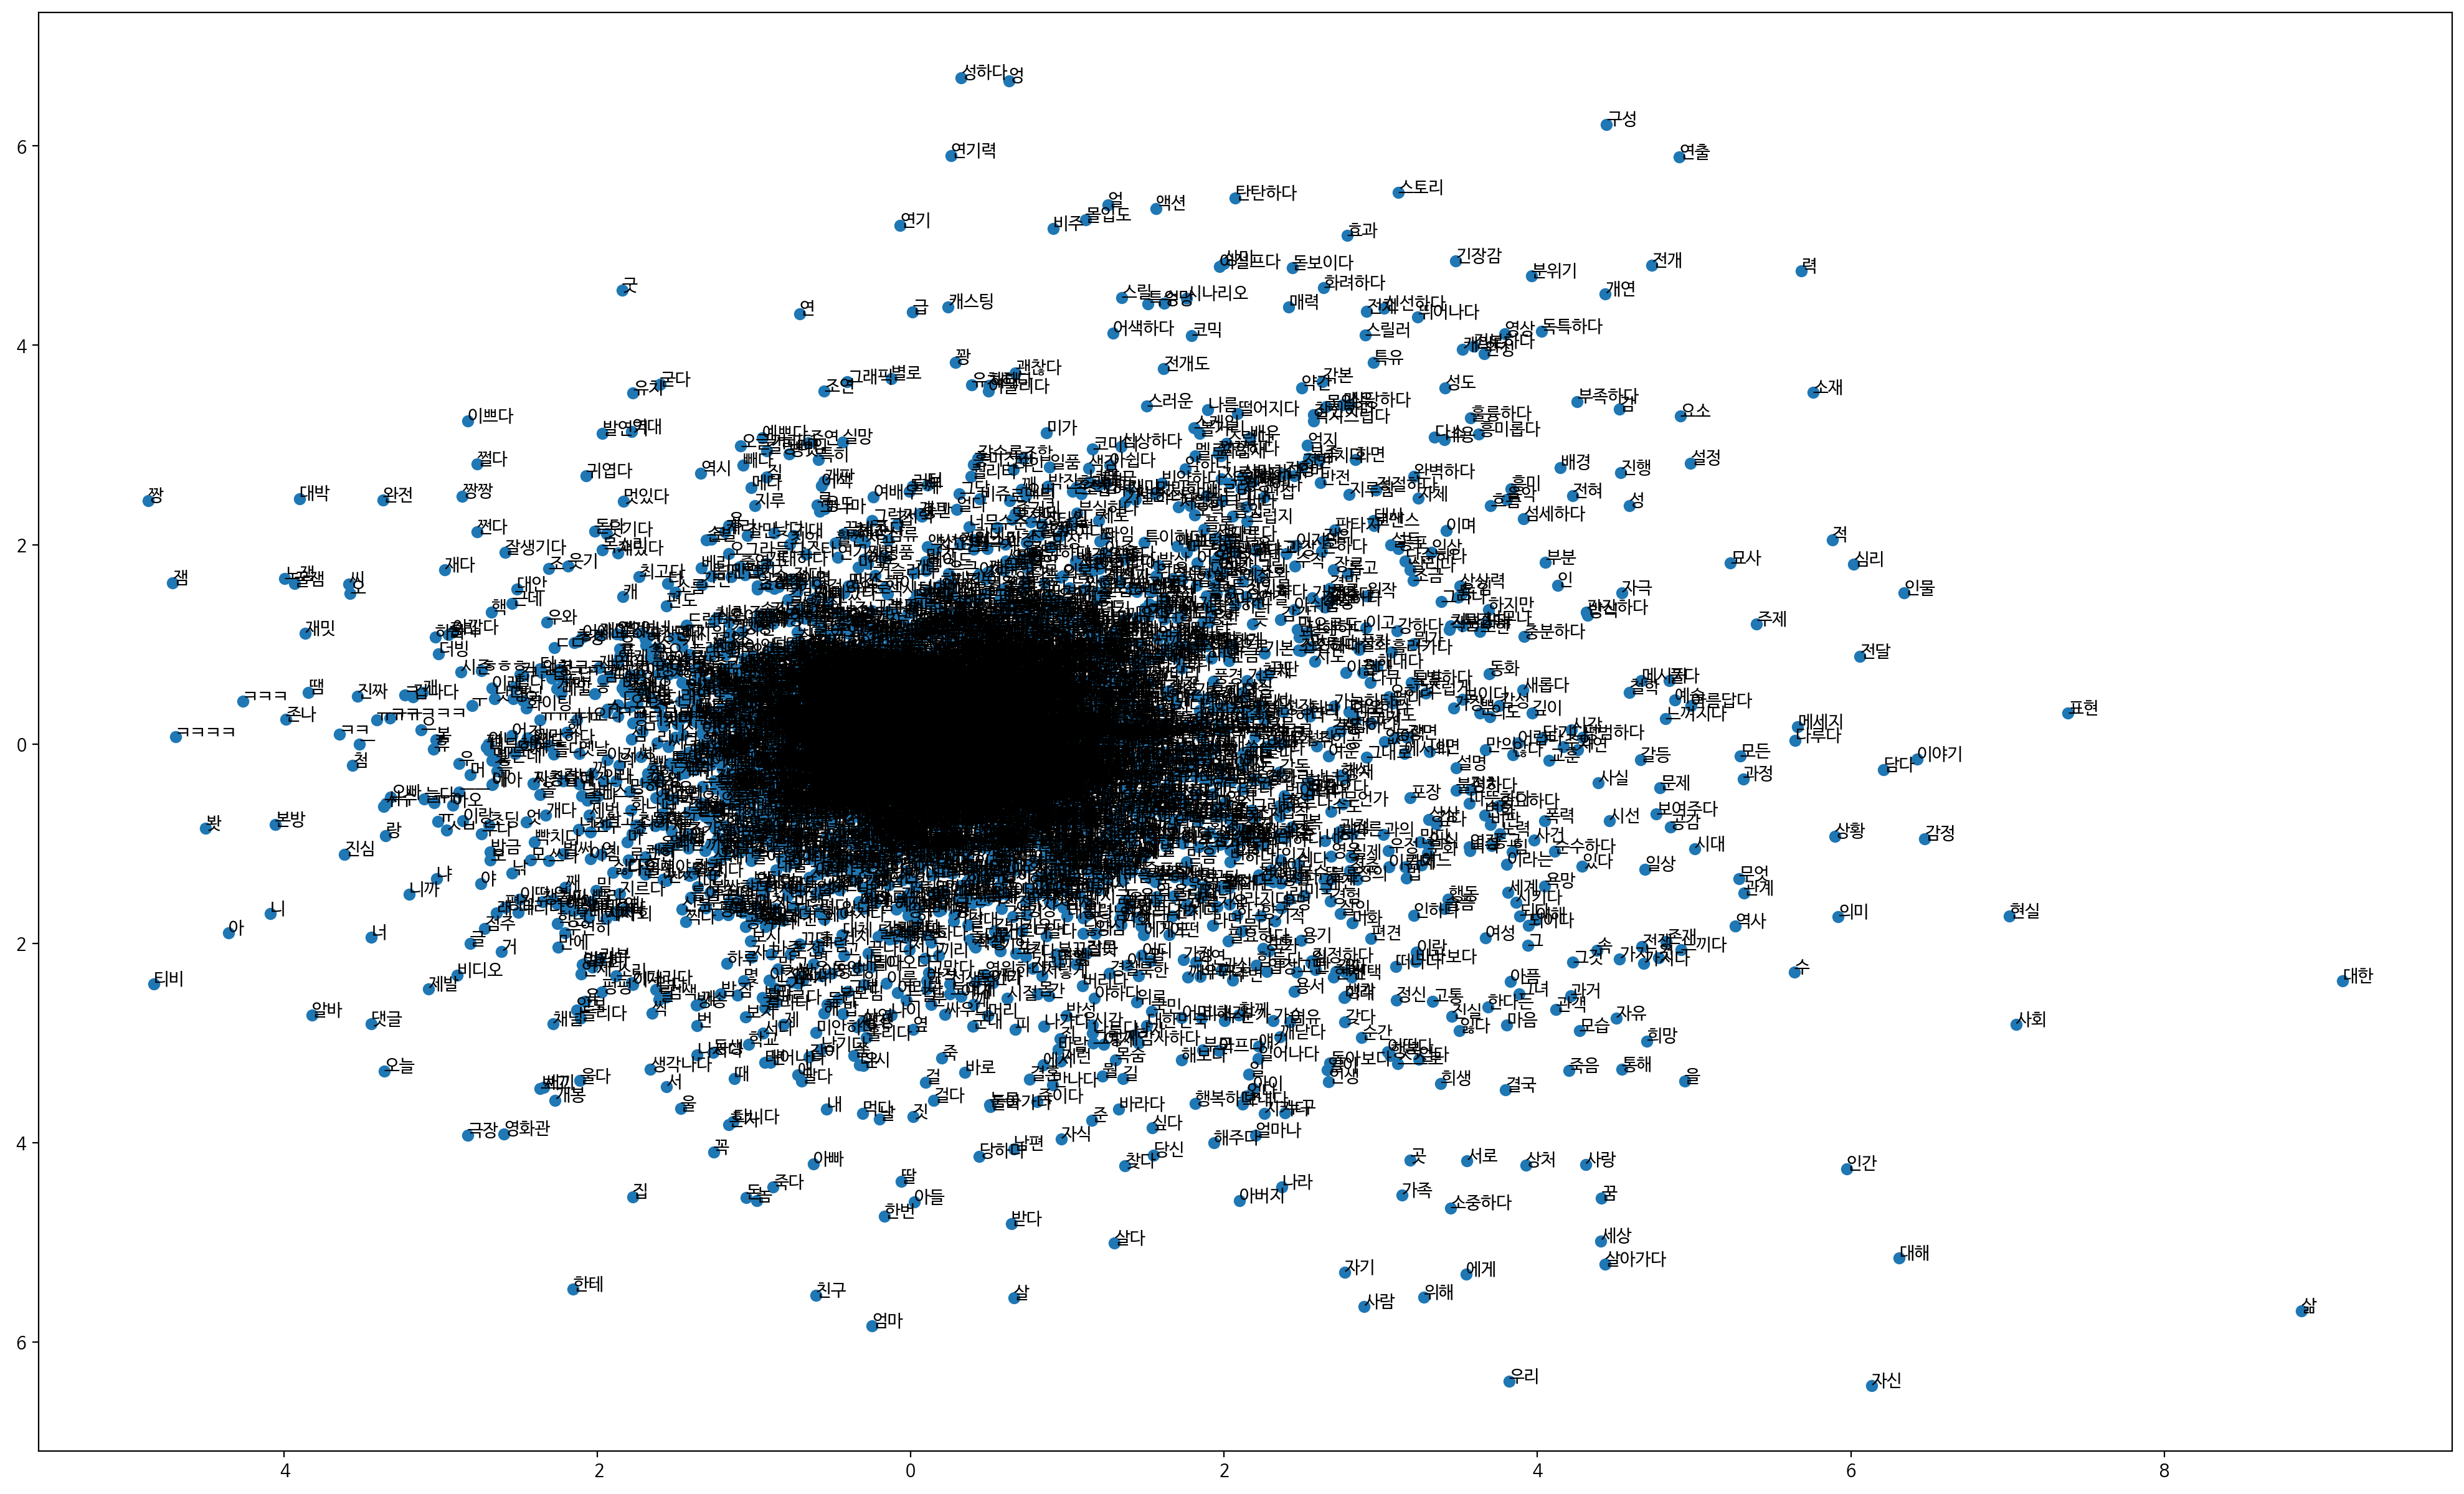

In [23]:
plot_2d_graph(vocabs,xs,ys)